In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Transform: normalize to [0,1], flatten later
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 -> 784
])

# 3. Load MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:

# 5. Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)   # logits
        return self.softmax(x)

model = MLP().to(device)

# 6. Loss & Optimizer
criterion = nn.CrossEntropyLoss()   # combines Softmax + NLL
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:

# 7. Training loop
num_epochs = 15
losses, accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")





Epoch 1/15, Loss: 1.5552, Accuracy: 0.9102
Epoch 2/15, Loss: 1.5129, Accuracy: 0.9482
Epoch 3/15, Loss: 1.5021, Accuracy: 0.9592
Epoch 4/15, Loss: 1.5003, Accuracy: 0.9607
Epoch 5/15, Loss: 1.4974, Accuracy: 0.9637
Epoch 6/15, Loss: 1.4971, Accuracy: 0.9638
Epoch 7/15, Loss: 1.4960, Accuracy: 0.9650
Epoch 8/15, Loss: 1.4970, Accuracy: 0.9640
Epoch 9/15, Loss: 1.4955, Accuracy: 0.9655
Epoch 10/15, Loss: 1.4929, Accuracy: 0.9681
Epoch 11/15, Loss: 1.4939, Accuracy: 0.9672
Epoch 12/15, Loss: 1.4921, Accuracy: 0.9690
Epoch 13/15, Loss: 1.4911, Accuracy: 0.9700
Epoch 14/15, Loss: 1.4935, Accuracy: 0.9677
Epoch 15/15, Loss: 1.4928, Accuracy: 0.9683


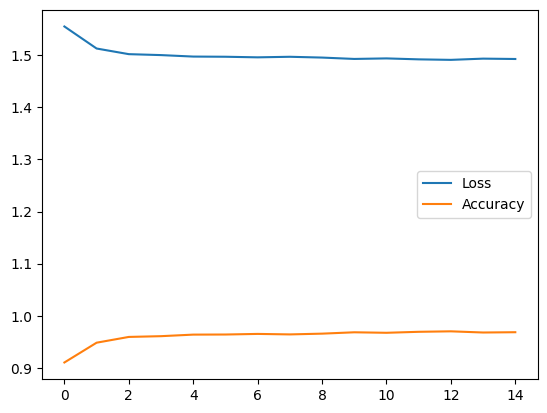

In [17]:

# 8. Plot loss & accuracy
plt.plot(losses, label="Loss")
plt.plot(accuracies, label="Accuracy")
plt.legend()
plt.show()


Predicted: [9 9 9 9 9 9 9 9 9 9]
Actual:    [7 2 1 0 4 1 4 9 5 9]


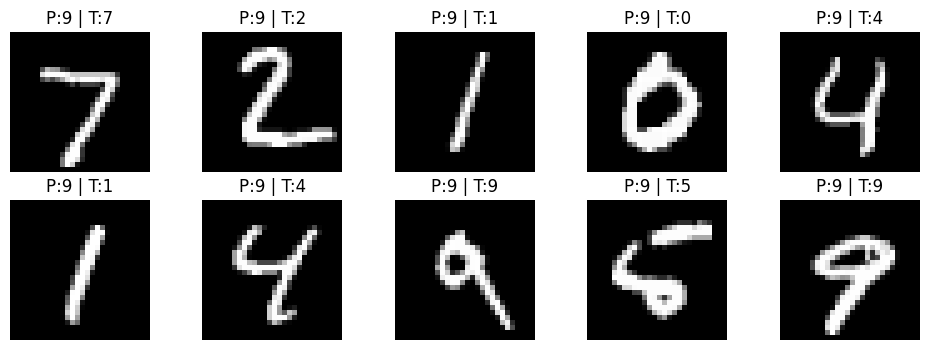

In [14]:
# ===== INFERENCE =====
import torch.nn.functional as F

model.eval()  # set to evaluation mode (important for layers like dropout/batchnorm)

with torch.no_grad():  # no gradients needed
    images, labels = next(iter(test_loader))  # take one batch
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)             # forward pass
    _, predicted = torch.max(outputs, 1)  # get class with highest probability

# Print first 10 predictions vs actual
print("Predicted:", predicted[:10].cpu().numpy())
print("Actual:   ", labels[:10].cpu().numpy())

# Plot a few examples
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().view(28, 28), cmap="gray")
    plt.title(f"P:{predicted[i].item()} | T:{labels[i].item()}")
    plt.axis("off")
plt.show()
